In [1]:
from pathlib import Path

import os
import re
import json
import numpy as np
import pandas as pd

def load_json(path: str | Path) -> object:
    """Loads a JSON file from disk and returns the deserialized object."""
    with open(path, "r") as f_in:
        return json.load(f_in)

In [36]:
# ROOT_DIR = Path("/fast/groups/sf/")    # CLUSTER
ROOT_DIR = Path("/Volumes/sf/")          # LOCAL

RESULTS_ROOT_DIR = ROOT_DIR / "folktexts-results" / "2024-06-05"
RESULTS_ROOT_DIR = ROOT_DIR / "folktexts-results" / "2024-06-05_2"

DATA_DIR = ROOT_DIR / "data"

## Local paths
def correct_path(p):
    finder_str = "folktexts-results"
    new_p = ROOT_DIR / p[p.find(finder_str):]
    return new_p.resolve()

Important results columns:

In [3]:
model_col = "config_model_name"
# model_col = "model_name"
feature_subset_col = "config_feature_subset"
population_subset_col = "config_population_filter"
predictions_path_col = "predictions_path"

uses_all_features_col = "uses_all_features"
uses_all_samples_col = "uses_all_samples"

In [4]:
def find_files(root_folder, pattern):
    # Compile the regular expression pattern
    regex = re.compile(pattern)

    # Walk through the directory tree
    for dirpath, dirnames, filenames in os.walk(root_folder):
        for filename in filenames:
            if regex.match(filename):
                # If the filename matches the pattern, add it to the list
                yield os.path.join(dirpath, filename)

def parse_model_name(name: str) -> str:
    name = name[name.find("--")+2:]
    return name

def get_non_instruction_tuned_name(name):
    name = name.replace("-Instruct", "")
    name = name.replace("-Chat", "")
    name = name.replace("-it", "")
    name = name.replace("-1.1", "")
    name = name.replace("-v0.2", "-v0.1")
    return name

def parse_results_dict(dct) -> dict:
    """Parses results dict; brings all information to the top-level."""
    dct = dct.copy()
    dct.pop("plots", None)
    config = dct.pop("config", {})
    for key, val in config.items():
        dct[f"config_{key}"] = val

    # Parse model name
    dct[model_col] = parse_model_name(dct[model_col])
    dct[uses_all_features_col] = dct[feature_subset_col] is None
    if dct[feature_subset_col] is None:
        dct[feature_subset_col] = "full"

    dct[uses_all_samples_col] = dct[population_subset_col] is None

    dct["base_name"] = get_non_instruction_tuned_name(dct[model_col])
    dct["is_inst"] = dct["base_name"] != dct[model_col]

    assert not any(isinstance(val, dict) for val in dct.values()), dct
    return dct

In [5]:
# Results file name pattern
pattern = r'^results.bench-(?P<hash>\d+)[.]json$'

# Find results files and aggregate
results = {}
for file_path in find_files(RESULTS_ROOT_DIR, pattern):
    results[Path(file_path).parent.name] = parse_results_dict(load_json(file_path))

In [6]:
df = pd.DataFrame(list(results.values()))
df = df.set_index(df[model_col].rename("model"), drop=False)

print(f"{df.shape=}")
df.sample(3)

df.shape=(70, 57)


,accuracy,accuracy_diff,accuracy_ratio,balanced_accuracy,balanced_accuracy_diff,balanced_accuracy_ratio,brier_score_loss,ece,ece_quantile,equalized_odds_diff,...,config_model_name,config_population_filter,config_reuse_few_shot_examples,config_seed,config_task_hash,config_task_name,uses_all_features,uses_all_samples,base_name,is_inst
model,,,,,,,,,,,,,,,,,,,,,
Mixtral-8x7B-v0.1,0.606260,0.264868,0.667092,0.500314,0.007568,0.985089,0.224986,0.111223,0.120032,0.016535,...,Mixtral-8x7B-v0.1,None,False,42,503311427,ACSIncome_AGEP_COW_RAC1P_SCHL,False,True,Mixtral-8x7B-v0.1,False
Mixtral-8x7B-Instruct-v0.1,0.711169,0.100159,0.874385,0.679513,0.209162,0.713035,0.261323,0.245778,0.245095,0.703850,...,Mixtral-8x7B-Instruct-v0.1,None,False,42,503311427,ACSIncome_AGEP_COW_RAC1P_SCHL,False,True,Mixtral-8x7B-v0.1,True
Mistral-7B-Instruct-v0.2,0.699892,0.109907,0.862140,0.673550,0.156930,0.780845,0.289475,0.285442,0.258033,0.593613,...,Mistral-7B-Instruct-v0.2,None,False,42,1879551727,ACSIncome_AGEP_COW_SCHL,False,True,Mistral-7B-v0.1,True


Evaluating LR and GBM:

In [7]:
%%time
from folktexts.acs.acs_dataset import ACSDataset
acs_income_dt = ACSDataset(task="ACSIncome", cache_dir=DATA_DIR)

Loading ACS data...
CPU times: user 37.8 s, sys: 13.3 s, total: 51.1 s
Wall time: 1min 26s


In [8]:
X_train, y_train = acs_income_dt.get_train()
X_test, y_test = acs_income_dt.get_test()

In [9]:
%%time
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(X_train, y_train)

CPU times: user 25.4 s, sys: 30 s, total: 55.4 s
Wall time: 6.54 s


/Users/acruz/opt/miniconda3/envs/folktexts/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [10]:
%%time
from sklearn.ensemble import HistGradientBoostingClassifier
gbm = HistGradientBoostingClassifier()
gbm.fit(X_train, y_train)

CPU times: user 32.5 s, sys: 14.5 s, total: 47 s
Wall time: 5.75 s


HistGradientBoostingClassifier()

In [11]:
%%time
from folktexts.evaluation import evaluate_predictions
lr_scores = lr.predict_proba(X_test)[:, -1]
lr_results = evaluate_predictions(y_test.to_numpy(), lr_scores, threshold=0.5)

gbm_scores = gbm.predict_proba(X_test)[:, -1]
gbm_results = evaluate_predictions(y_test.to_numpy(), gbm_scores, threshold=0.5)

CPU times: user 2.34 s, sys: 2.79 s, total: 5.13 s
Wall time: 550 ms


In [12]:
lr_results[model_col] = "LR"
gbm_results[model_col] = "GBM"

for r in [lr_results, gbm_results]:
    r[uses_all_features_col] = True
    r[uses_all_samples_col] = True
    r["base_name"] = r[model_col]

Add LR and GBM results to table:

In [13]:
df = pd.concat((df, pd.DataFrame([gbm_results, lr_results], index=["GBM", "LR"])))

In [14]:
def _helper(val):
    try:
        return len(val)
    except Exception:
        return 10

df["num_features"] = df[feature_subset_col].map(_helper)

In [15]:
from datetime import datetime
def get_current_timestamp() -> str:
    """Return a timestamp representing the current time up to the second."""
    return datetime.now().strftime("%Y.%m.%d-%H.%M.%S")

df.to_csv(Path(RESULTS_ROOT_DIR) / f"aggregated_results.{get_current_timestamp()}.csv")

# Analyze results

In [16]:
df_full_data = df[df[uses_all_features_col] & df[uses_all_samples_col]]
# df_full_data = df[df[feature_subset_col].isna()]
print(f"{df_full_data.shape=}")
df_full_data.head(2)

df_full_data.shape=(16, 58)


,accuracy,accuracy_diff,accuracy_ratio,balanced_accuracy,balanced_accuracy_diff,balanced_accuracy_ratio,brier_score_loss,ece,ece_quantile,equalized_odds_diff,...,config_population_filter,config_reuse_few_shot_examples,config_seed,config_task_hash,config_task_name,uses_all_features,uses_all_samples,base_name,is_inst,num_features
Meta-Llama-3-8B-Instruct,0.602788,0.081996,0.877289,0.668226,0.108936,0.854670,0.312975,0.342065,0.342065,0.318946,...,None,False,42.0,843421931.0,ACSIncome,True,True,Meta-Llama-3-8B,True,4
Meta-Llama-3-70B,0.727275,0.094978,0.882897,0.757823,0.106635,0.866587,0.195809,0.192376,0.192159,0.331146,...,None,False,42.0,843421931.0,ACSIncome,True,True,Meta-Llama-3-70B,False,4


In [17]:
df.sort_values("ece")[[model_col, feature_subset_col, "ece"]]

,config_model_name,config_feature_subset,ece
GBM,GBM,NaN,0.008511
LR,LR,NaN,0.031498
Mixtral-8x7B-v0.1,Mixtral-8x7B-v0.1,"[AGEP, COW]",0.041188
Mixtral-8x7B-v0.1,Mixtral-8x7B-v0.1,"[AGEP, COW, SCHL, RAC1P, SEX]",0.088267
Mixtral-8x7B-v0.1,Mixtral-8x7B-v0.1,"[AGEP, COW, SCHL]",0.089387
...,...,...,...
gemma-1.1-2b-it,gemma-1.1-2b-it,full,0.600910
gemma-1.1-2b-it,gemma-1.1-2b-it,"[AGEP, COW, SCHL, RAC1P]",0.601208
gemma-1.1-2b-it,gemma-1.1-2b-it,"[AGEP, COW, SCHL]",0.601924
gemma-1.1-2b-it,gemma-1.1-2b-it,"[AGEP, COW]",0.603736


In [18]:
metrics = ["ece", "brier_score_loss", "log_loss", "roc_auc", "accuracy"]

In [19]:
latex_table = df_full_data.sort_values("base_name")[metrics].round(4)
latex_table = latex_table.rename(columns=lambda col: col.replace("_", " "))
latex_table

,ece,brier score loss,log loss,roc auc,accuracy
GBM,0.0085,0.1303,0.4025,0.8919,0.8098
LR,0.0315,0.1813,0.5412,0.7890,0.7335
Meta-Llama-3-70B,0.1924,0.1958,0.5796,0.8616,0.7273
Meta-Llama-3-70B-Instruct,0.2665,0.2632,1.3944,0.8639,0.6887
Meta-Llama-3-8B-Instruct,0.3421,0.3130,1.0772,0.8562,0.6028
Meta-Llama-3-8B,0.2263,0.2645,0.7218,0.8030,0.3946
Mistral-7B-Instruct-v0.2,0.2206,0.2297,1.9563,0.8413,0.7516
Mistral-7B-v0.1,0.2036,0.2341,0.6613,0.7855,0.7301
Mixtral-8x7B-Instruct-v0.1,0.1760,0.1950,0.9410,0.8534,0.7699
Mixtral-8x7B-v0.1,0.1754,0.2185,0.6272,0.8087,0.6120


In [20]:
print(latex_table.to_latex(float_format="%.2f"))

\begin{tabular}{lrrrrr}
\toprule
 & ece & brier score loss & log loss & roc auc & accuracy \\
\midrule
GBM & 0.01 & 0.13 & 0.40 & 0.89 & 0.81 \\
LR & 0.03 & 0.18 & 0.54 & 0.79 & 0.73 \\
Meta-Llama-3-70B & 0.19 & 0.20 & 0.58 & 0.86 & 0.73 \\
Meta-Llama-3-70B-Instruct & 0.27 & 0.26 & 1.39 & 0.86 & 0.69 \\
Meta-Llama-3-8B-Instruct & 0.34 & 0.31 & 1.08 & 0.86 & 0.60 \\
Meta-Llama-3-8B & 0.23 & 0.26 & 0.72 & 0.80 & 0.39 \\
Mistral-7B-Instruct-v0.2 & 0.22 & 0.23 & 1.96 & 0.84 & 0.75 \\
Mistral-7B-v0.1 & 0.20 & 0.23 & 0.66 & 0.79 & 0.73 \\
Mixtral-8x7B-Instruct-v0.1 & 0.18 & 0.20 & 0.94 & 0.85 & 0.77 \\
Mixtral-8x7B-v0.1 & 0.18 & 0.22 & 0.63 & 0.81 & 0.61 \\
Yi-34B-Chat & 0.26 & 0.23 & 0.73 & 0.86 & 0.67 \\
Yi-34B & 0.24 & 0.23 & 0.64 & 0.86 & 0.60 \\
gemma-1.1-2b-it & 0.60 & 0.60 & 3.19 & 0.72 & 0.39 \\
gemma-2b & 0.11 & 0.25 & 0.69 & 0.64 & 0.56 \\
gemma-7b & 0.22 & 0.27 & 0.74 & 0.64 & 0.39 \\
gemma-1.1-7b-it & 0.59 & 0.57 & 3.19 & 0.84 & 0.39 \\
\bottomrule
\end{tabular}



---

## Score distribution plot

In [21]:
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_style("whitegrid", rc={"grid.linestyle": "--"})
sns.color_palette("colorblind")

[(0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
 (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
 (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
 (0.8352941176470589, 0.3686274509803922, 0.0),
 (0.8, 0.47058823529411764, 0.7372549019607844),
 (0.792156862745098, 0.5686274509803921, 0.3803921568627451),
 (0.984313725490196, 0.6862745098039216, 0.8941176470588236),
 (0.5803921568627451, 0.5803921568627451, 0.5803921568627451),
 (0.9254901960784314, 0.8823529411764706, 0.2),
 (0.33725490196078434, 0.7058823529411765, 0.9137254901960784)]

In [37]:
model_scores = {
    row[model_col]: pd.read_csv(correct_path(row[predictions_path_col]), index_col=0)
    for _, row in df_full_data.iterrows()
    if not pd.isna(row[predictions_path_col])
}

In [38]:
from itertools import product

model_pairs = [
    (name_a, name_b)
    for name_a, name_b in product(df_full_data[model_col].unique(), df_full_data[model_col].unique())
    if name_a == get_non_instruction_tuned_name(name_b) and name_a != name_b
]
model_pairs

[('Meta-Llama-3-70B', 'Meta-Llama-3-70B-Instruct'),
 ('Meta-Llama-3-8B', 'Meta-Llama-3-8B-Instruct'),
 ('gemma-7b', 'gemma-1.1-7b-it'),
 ('Yi-34B', 'Yi-34B-Chat'),
 ('Mixtral-8x7B-v0.1', 'Mixtral-8x7B-Instruct-v0.1'),
 ('Mistral-7B-v0.1', 'Mistral-7B-Instruct-v0.2'),
 ('gemma-2b', 'gemma-1.1-2b-it')]

In [48]:
# model_pairs_to_plot = model_pairs
# model_pairs_to_plot = model_pairs[:4]
model_pairs_to_plot = [model_pairs[1], model_pairs[0], model_pairs[3], model_pairs[5], model_pairs[4]]
model_pairs_to_plot

[('Meta-Llama-3-8B', 'Meta-Llama-3-8B-Instruct'),
 ('Meta-Llama-3-70B', 'Meta-Llama-3-70B-Instruct'),
 ('Yi-34B', 'Yi-34B-Chat'),
 ('Mistral-7B-v0.1', 'Mistral-7B-Instruct-v0.2'),
 ('Mixtral-8x7B-v0.1', 'Mixtral-8x7B-Instruct-v0.1')]

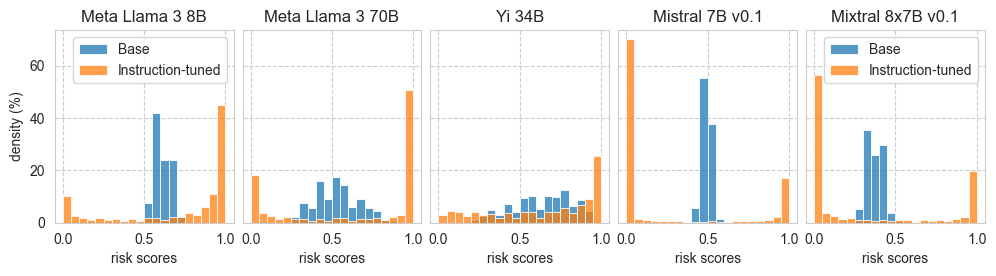

In [50]:
fig, axes = plt.subplots(ncols=len(model_pairs_to_plot), sharey=True, figsize=(12, 2.5), gridspec_kw=dict(wspace=0.05))

for idx, (base_model, it_model) in enumerate(model_pairs_to_plot):
    ax = axes[idx]
    
    base_scores = model_scores[base_model]["risk_score"]
    it_scores = model_scores[it_model]["risk_score"]
    
    n_bins = 20
    plot_config = dict(
        bins=n_bins,
        binrange=(0, 1),
        stat="percent",
        ax=ax,
    )
    
    ax.set_xlabel("risk scores")
    if idx == 0:
        ax.set_ylabel("density (%)")
    
    def get_label(model_name, base: bool):
        return (
            # f"{model_name}\n" 
            ("Base" if base else "Instruction-tuned")
            # + "\n"
            # + r"($\text{ece}=" + f"{df_full_data.loc[model_name]['ece']:.2f}"
            # + r", \text{roc}=" + f"{df_full_data.loc[model_name]['roc_auc']:.2f}"
            # + r"$)"
        )

    ax.set_title(base_model.replace("-", " "))

    sns.histplot(base_scores,label=get_label(base_model, base=True), **plot_config)
    sns.histplot(it_scores, label=get_label(it_model, base=False), **plot_config)
    # sns.histplot(gbm_scores, label="GBM", **plot_config, alpha=0.3)   # Plot GBM results as proxy for Bayes optimal?

    if idx == 0 or idx == len(model_pairs_to_plot) - 1:
        ax.legend()

plt.savefig(Path(RESULTS_ROOT_DIR) / "score-distribution.pdf", bbox_inches="tight")

## Plot on subsets of features

In [51]:
df.groupby(model_col).count()[feature_subset_col]

config_model_name
GBM                           0
LR                            0
Meta-Llama-3-70B              5
Meta-Llama-3-70B-Instruct     5
Meta-Llama-3-8B               5
Meta-Llama-3-8B-Instruct      5
Mistral-7B-Instruct-v0.2      5
Mistral-7B-v0.1               5
Mixtral-8x7B-Instruct-v0.1    5
Mixtral-8x7B-v0.1             5
Yi-34B                        5
Yi-34B-Chat                   5
gemma-1.1-2b-it               5
gemma-1.1-7b-it               5
gemma-2b                      5
gemma-7b                      5
Name: config_feature_subset, dtype: int64

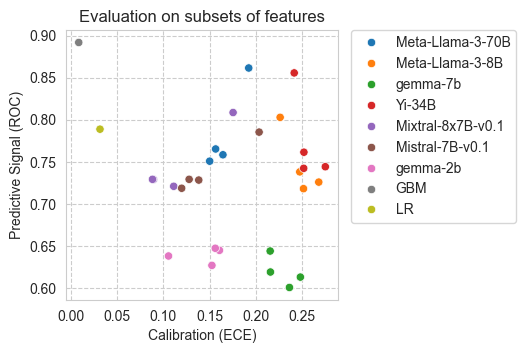

In [52]:
scatter_data = df[((df["is_inst"] == False) | (df["is_inst"].isna())) & (df["num_features"] > 2)]

plt.figure(figsize=(3.5,3.5))
sns.scatterplot(scatter_data, x="ece", y="roc_auc", hue="base_name")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.xlabel("Calibration (ECE)")
plt.ylabel("Predictive Signal (ROC)")

plt.title("Evaluation on subsets of features")

# TODO: use different style for non-LLM markers

plt.savefig(Path(RESULTS_ROOT_DIR) / "features-subsets.pdf", bbox_inches="tight")